In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV, BandedRidgeCV
from scipy.stats import zscore

In [2]:
np.random.seed(42)
backend = set_backend("cupy")
plt.style.use("nord")
sns.set_theme(style="whitegrid")

In [3]:
n_samples_train = 1000
n_samples_test = 100
n_targets = 10000
d_list = [100, 100, 100]
scalars = [1/3, 1/3, 1/3]
noise_scalar = 0.1
hidden_feature_space_names = ["A", "B", "C"]
researcher_feature_space_names = [r"$X_1$", r"$X_2$"]

# Generate features

## Start with random matrix $M$

In [4]:
M = np.random.randn(n_samples_train + n_samples_test, sum(d_list))
M = zscore(M, axis=0)

## SVD

In [5]:
U, S, Vt = np.linalg.svd(M, full_matrices=False)
print(U.shape, S.shape, Vt.shape)

(1100, 300) (300,) (300, 300)


Text(17.31944444444445, 0.5, 'value')

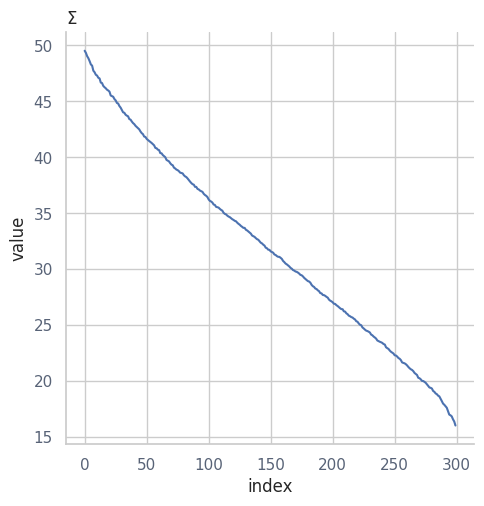

In [6]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$")
plt.xlabel("index")
plt.ylabel("value")

### Shuffle U, S and V indices to remove singular value order

In [7]:
index_shuffle = list(range(U.shape[1]))
random.shuffle(index_shuffle)
U = U[:, index_shuffle]
S = S[index_shuffle]
Vt = Vt[index_shuffle, :]

Text(17.31944444444445, 0.5, 'value')

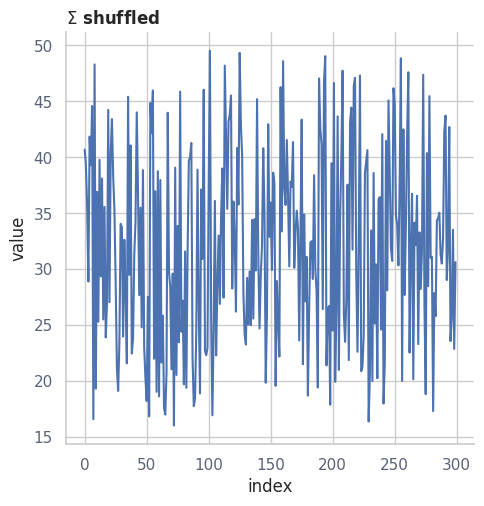

In [8]:
sns.relplot(S, kind="line")
plt.title(r"$\Sigma$ shuffled")
plt.xlabel("index")
plt.ylabel("value")

Split up S to create three orthogonal matrices to be used as feature spaces

In [9]:
feature_spaces = []

start = 0
for rank in d_list:
    _S = np.zeros(len(S))
    _S[start:start + rank] = S[start:start + rank]

    diag_S = np.diag(_S)

    space = U @ diag_S @ Vt
    feature_spaces.append(space)
    start += rank

#### make sure that all feature spaces are orthogonal to each other (histograms should be nearly 0)

In [10]:
import pandas as pd

matmuls_df = pd.DataFrame()

for i in range(len(feature_spaces)):
    for j in range(i + 1, len(feature_spaces)):
        first_transposed = feature_spaces[i].T @ feature_spaces[
            j]
        matmuls_df = pd.concat([
            matmuls_df,
            pd.DataFrame(
                {'Features': [f"{hidden_feature_space_names[i]}.T x {hidden_feature_space_names[j]}"],
                 'Values (avg across samples)': [first_transposed.mean(axis=0)]}), ], ignore_index=True)

for i in range(len(feature_spaces)):
    for j in range(i + 1, len(feature_spaces)):
        second_transposed = feature_spaces[i] @ feature_spaces[j].T
        matmuls_df = pd.concat([
            matmuls_df,
            pd.DataFrame(
                {'Features': [f"{hidden_feature_space_names[i]} x {hidden_feature_space_names[j]}.T"],
                 'Values (avg across samples)': [second_transposed.mean(axis=0)], }),
        ], ignore_index=True)
matmuls_df

,Features,Values (avg across samples)
0,A.T x B,"[-1.1566789193118154e-15, 1.071689033812125e-1..."
1,A.T x C,"[-3.999808658473418e-15, 4.575385209593108e-15..."
2,B.T x C,"[1.6986817045575957e-15, 2.286134244873968e-16..."
3,A x B.T,"[-5.648772169716568e-17, 6.139817190018639e-17..."
4,A x C.T,"[4.758898452074011e-17, 5.092675019065366e-17,..."
5,B x C.T,"[4.6831989635719035e-17, -8.453149796300801e-1..."


Text(0.5, 1.02, 'Feature space matrix multiplications')

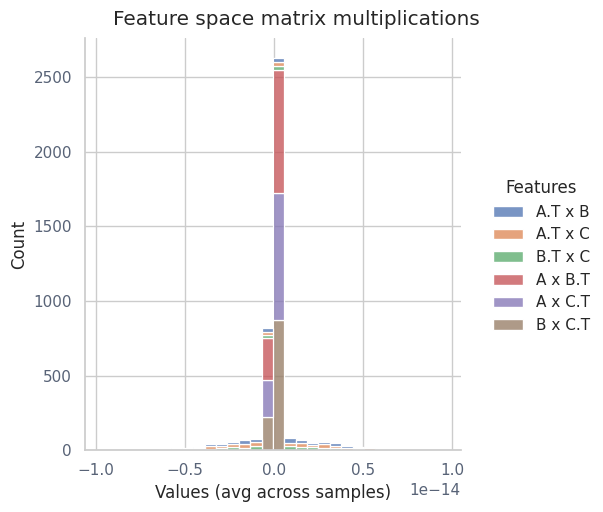

In [11]:
sns.displot(data=matmuls_df.explode("Values (avg across samples)"), x="Values (avg across samples)", multiple="stack",
            hue="Features", bins=30)
plt.suptitle("Feature space matrix multiplications", y=1.02)

# Generate weights

In [12]:
betas = [zscore(np.random.randn(sum(d_list), n_targets)) for _ in d_list]

# create targets

In [13]:
Y = sum([(alpha ** 0.5) * zscore(feature_space @ beta) for alpha, feature_space, beta in zip(scalars, feature_spaces, betas)])
Y = zscore(Y)

## add noise

In [14]:
noise = zscore(np.random.randn(n_samples_train + n_samples_test, n_targets), axis=0)

In [15]:
Y += noise * (noise_scalar ** 0.5)
Y = zscore(Y)

# train simple linear models to confirm feature spaces predict the target

In [16]:
def r2(prediction, actual):
    ssres = np.sum((prediction - actual) ** 2)
    sstot = np.sum((actual - actual.mean()) ** 2)
    score = 1 - (ssres / sstot)
    return score

In [17]:
scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(feature_spaces))]

for i, model in enumerate(linear_models):
    model.fit(feature_spaces[i][:n_samples_train], Y[:n_samples_train])
    prediction = model.predict(feature_spaces[i][n_samples_train:])
    score = r2(prediction, Y[n_samples_train:])
    scores = pd.concat([
        scores,
        pd.DataFrame({'feature space': [hidden_feature_space_names[i]], 'Score': [score],
                      'EV': [scalars[i]]})], ignore_index=True
    )
scores

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/backend/_utils.py:138: UserWarning: GPU backend cupy is much faster with single precision floats (float32), got input in float64. Consider casting your data to float32.
  warnings.warn(


,feature space,Score,EV
0,A,0.158277,0.333333
1,B,0.161982,0.333333
2,C,0.154653,0.333333


Text(0.0, 1.0, 'Feature space scores')

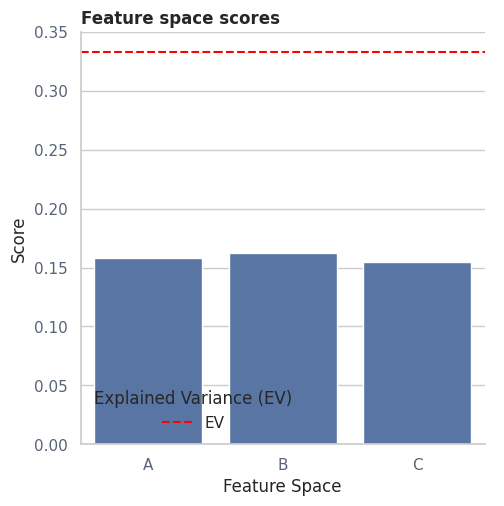

In [18]:
plot = sns.catplot(scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space", "Score")
for index, row in scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 3, xmax=(index + 1) / 3,
                    label=f'EV' if index == 0 else None)
plot.ax.legend(title="Explained Variance (EV)")
plt.title("Feature space scores")

Create researcher feature spaces

In [19]:
Xs = [np.hstack([feature_spaces[0], feature_space]) for feature_space in feature_spaces[1:]]

now train on researcher side feature spaces

In [20]:
researcher_scores = pd.DataFrame()

linear_models = [RidgeCV() for _ in range(len(Xs))]
for i, model in enumerate(linear_models):
    model.fit(Xs[i][:n_samples_train], Y[:n_samples_train])
    prediction = model.predict(Xs[i][n_samples_train:])
    score = r2(prediction, Y[n_samples_train:])
    researcher_scores = pd.concat([
        researcher_scores,
        pd.DataFrame({'feature space': [researcher_feature_space_names[i]], 'Score': [score],
                      'EV': scalars[0] + scalars[i + 1]})],
        ignore_index=True
    )
researcher_scores

,feature space,Score,EV
0,$X_1$,0.428380,0.666667
1,$X_2$,0.421452,0.666667


Text(0.0, 1.0, 'Researcher side feature space scores')

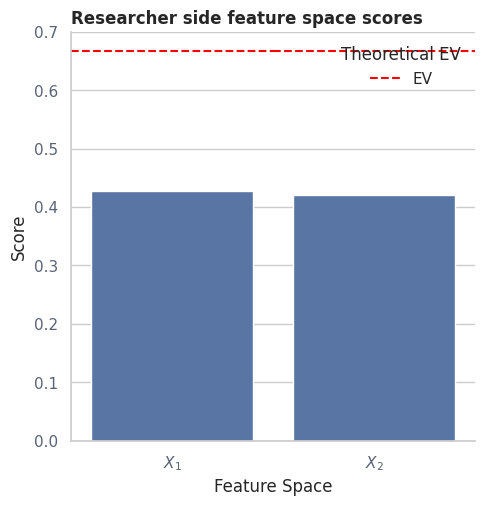

In [21]:
plot = sns.catplot(researcher_scores, x="feature space", y="Score", kind="bar").set_axis_labels("Feature Space",
                                                                                                "Score")
for index, row in researcher_scores.iterrows():
    plot.ax.axhline(row["EV"], color='red', linestyle="--", linewidth=1.5,
                    xmin=index / 2, xmax=(index + 1) / 2,
                    label=f'EV' if index == 0 else None)
plot.ax.legend(title="Theoretical EV")
plt.title("Researcher side feature space scores")

In [24]:
Xs_train = [x[:n_samples_train] for x in Xs]
Xs_test = [x[n_samples_train:] for x in Xs]
joint_model = BandedRidgeCV(groups="input")
joint_model.fit(Xs_train, Y[:n_samples_train])
score = joint_model.score(Xs_test, Y[n_samples_train:])

[                                        ] 0% | 0.00 sec | 100 random sampling with cv | 

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:140: UserWarning: Solving banded ridge is slower than solving multiple-kernel ridge when n_samples < n_features (here 1000 < 1200). Using linear kernels in himalaya.kernel_ridge.MultipleKernelRidgeCV or himalaya.kernel_ridge.solve_multiple_kernel_ridge_random_search would be faster. Use warn=False to silence this warning.
  warnings.warn(


[........................................] 100% | 197.45 sec | 100 random sampling with cv | 


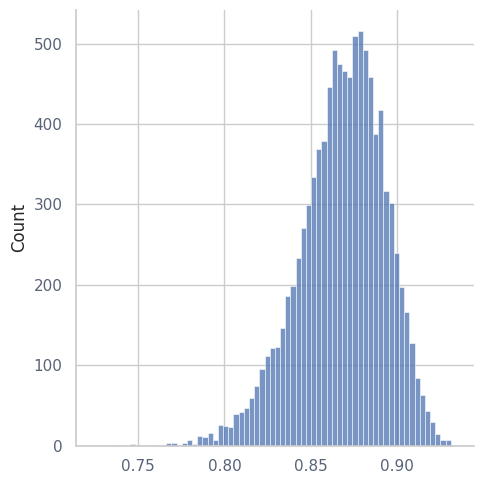

In [26]:
sns.displot(backend.to_numpy(score))